In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 150

In [3]:
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import interact, fixed


# Data
# from transat.data import HYPOTHETICAL_SUBMISSION_DATE
from transat.data.load import download_historical, load_historical
from transat.data.split import split_historical
from transat.data.transform import preprocess_historical_basic, dataframe_to_array

# Metric
from transat.metric import mae

# Scenario/Simulation
from transat.data.scenario import generate_scenario

In [4]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-09-30")

In [6]:
def download_csv(url, path, prefix):
    """
    Downloads a CSV from 'url', saves it to 'path' folder with filename 'prefix'_DD-MM-YYYY formatted at today's date
    """
    import requests
    import os
    import datetime
    response = requests.get(url, allow_redirects=True)
    today = str(datetime.date.today())
    os.makedirs(path, exist_ok=True)
    filepath = f'{path}/{prefix}_{today}.csv'
    open(filepath, 'wb').write(response.content)
    return filepath

def update_owid(path):
    """
    Updates Our World In Data database and saves it to 'path' folder. Renames it to owid_DD-MM-YYYY with today's date
    """
    filepath = download_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv', path, 'owid')
    print(f'Downloaded Our World In Data Coronavirus data to \n\t{filepath}')
    return filepath

# Create a "owid-data"
owid_filepath = update_owid("data")

Downloaded Our World In Data Coronavirus data to 
	data/owid_2020-12-16.csv


In [7]:
df_owid = pd.read_csv(owid_filepath)

subdf = df_owid[["iso_code", "population"]]
subdf = subdf.drop_duplicates()

countryCode_2_population = {iso:pop for iso,pop in zip(subdf.iso_code, subdf.population)}

In [6]:
download_historical()
df = load_historical()

In [7]:
df = preprocess_historical_basic(df)

In [8]:
print("Spliting at : ", HYPOTHETICAL_SUBMISSION_DATE)
df_train, df_test = split_historical(df, HYPOTHETICAL_SUBMISSION_DATE)

Spliting at :  2020-09-30


In [36]:
nb_lookback_days = 30
nb_lookahead_days = 1
sequence_format = True
neg_npis = False

(X_train, y_train), (X_cols, y_col) = dataframe_to_array(df_train, nb_lookback_days=nb_lookback_days, 
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis)
(X_test, y_test), _ = dataframe_to_array(df_test, nb_lookback_days=nb_lookback_days,
    nb_lookahead_days=nb_lookahead_days, sequence_format=sequence_format, neg_npis=neg_npis)

# X_train, y_train = X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1)
# X_test, y_test = X_test.reshape(X_test.shape[0], -1), y_test.reshape(-1)

print("X_train shape: ", np.shape(X_train))
print("y_train shape: ", np.shape(y_train))
print()
print("X_test  shape: ", np.shape(X_test))
print("y_test  shape: ", np.shape(y_test))

X_train shape:  (67760, 30, 13)
y_train shape:  (67760, 1, 1)

X_test  shape:  (12600, 30, 13)
y_test  shape:  (12600, 1, 1)


In [37]:
class LSTM:
    
    def fit(self, X, y, X_valid, y_valid, epochs=1, batch_size=32):
        
        # Build Model
        if not(hasattr(self, "model")):
            input_shape = X.shape[1:]
            self.model = self.build_model(input_shape)
            
        # Pre-process data
        self.fit_preprocess(X, y)
        X, y = self.transform(X, y)
        X_valid, y_valid = self.transform(X_valid, y_valid)
        
        # callbacks
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.8, patience=5, verbose=1,
            mode='auto', min_delta=0.0001, cooldown=0, min_lr=0
        )
        
        # Fit Model
        history = self.model.fit(X, y, 
            epochs=epochs, 
            batch_size=batch_size,
            validation_data=(X_valid, y_valid),
            callbacks=[reduce_lr],
            shuffle=False,
        )
        
        return history
        
    def predict(self, X):
        X = self.transform(X)
        
        y = self.model.predict(X).reshape(-1)
        
        # Inverse preprocessing
#         y = y * self.std[0] + self.mean[0]
        y = y * (self.max[0] - self.min[0]) + self.min[0]
        
        return y
    
    def fit_preprocess(self, X, y):
        # MinMax (x - min) / (max - min)
        self.min = X.reshape(-1, X.shape[-1]).min(axis=0)
        self.max = X.reshape(-1, X.shape[-1]).max(axis=0)

        # Normalization
#         self.mean = X.reshape(-1, X.shape[-1]).mean(axis=0)
#         self.std = X.reshape(-1, X.shape[-1]).std(axis=0)

        
    
    
    def transform(self, X, y=None):
        X = (X - self.min) / (self.max - self.min)
#         X = (X - self.mean) / self.std
        if y is not None:
            y = (y - self.min[0]) / (self.max[0] - self.min[0])
#             y = (y - self.mean[0]) / self.std[0]
            return X, y
        else:
            return X
    
    def build_model(self, input_shape):

        input = tf.keras.Input(shape=input_shape, name='input')
        x = tf.keras.layers.LSTM(64, return_sequences=True)(input)
        x = tf.keras.layers.LSTM(64, return_sequences=False)(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        output = tf.keras.layers.Dense(1, activation=None, name='output')(x)
        model = tf.keras.Model(inputs=[input], outputs=[output])

        model.compile(
#             loss=tf.losses.MeanSquaredError(),
            loss=tf.keras.losses.MeanAbsoluteError(),
#             loss=tf.keras.losses.LogCosh(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
        )

        return model
    
model = LSTM()

In [38]:
hist = model.fit(X_train, y_train, X_test, y_test, epochs=20)

Epoch 1/20
2118/2118 [==============================] - 12s 6ms/step - loss: 0.0113 - mean_absolute_error: 0.0113 - val_loss: 0.0257 - val_mean_absolute_error: 0.0257 - lr: 0.0010
Epoch 2/20
2118/2118 [==============================] - 12s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0074 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307 - lr: 0.0010
Epoch 3/20
2118/2118 [==============================] - 12s 5ms/step - loss: 0.0071 - mean_absolute_error: 0.0071 - val_loss: 0.0293 - val_mean_absolute_error: 0.0293 - lr: 0.0010
Epoch 4/20
2118/2118 [==============================] - 12s 5ms/step - loss: 0.0070 - mean_absolute_error: 0.0070 - val_loss: 0.0295 - val_mean_absolute_error: 0.0295 - lr: 0.0010
Epoch 5/20
2118/2118 [==============================] - 13s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.0069 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251 - lr: 0.0010
Epoch 6/20
2118/2118 [==============================] - 12s 5ms/step - loss: 0.0068 - mean_absolute_

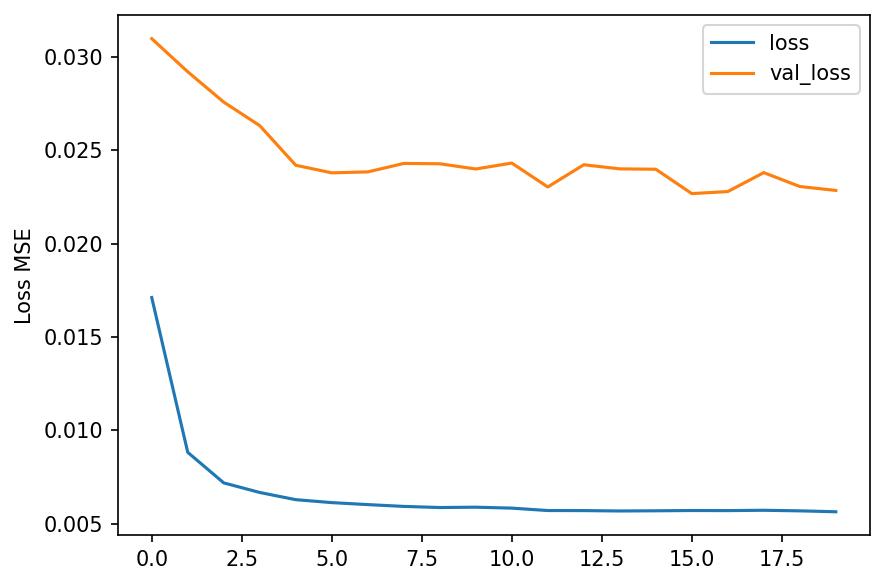

In [27]:
hist = hist.history

plt.figure()
# # plt.subplot(1,2,1)
# plt.ylabel("Test MAE")

# plt.plot(hists["no reduce_lr"]["val_loss"], label="NO ReduceLR")
# plt.plot(hists["reduce_lr"]["val_loss"], label="ReduceLR")

# plt.legend()

# plt.subplot(1,2,2)
plt.ylabel("Loss MSE")
plt.plot(hist["loss"], label="loss")
plt.plot(hist["val_loss"], label="val_loss")
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
# Evaluate model
# train_preds = model.predict(X_train)
# train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
# print('Train MAE:', mae(train_preds, y_train))

# valid_preds = model.predict(X_valid)
# valid_preds = np.maximum(valid_preds, 0) # Don't predict negative cases
# print('Valid MAE:', mae(valid_preds, y_valid))

test_preds = model.predict(X_test)
test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
print('Test MAE:', mae(test_preds, y_test))

MemoryError: Unable to allocate 298. GiB for an array with shape (9520, 21, 199920) and data type float64

In [39]:
def simulate_scenario(model, X_scenario, y_scenario, seq=False):
    # Simulate scenario

    X_sim = X_scenario.copy()
    X_sim_cases = X_sim[:,:,:1]
    X_sim_npis = X_sim[:,:,1:]
    y_sim = np.zeros(np.shape(y_scenario))

    nb_lookback_days = X_sim.shape[1]

    for d in range(y_sim.shape[1]):
        
        if seq:
            y = model.predict(X_sim)
        else:
            y = model.predict(X_sim.reshape(1,-1))
        y_sim[0,d,0] = max(y[0], 0)

        # Assuming constant NPIs here
        X_sim_npis = np.concatenate([X_sim_npis[:,1:], X_sim_npis[:,-1:]], axis=1)
        X_sim_cases = np.concatenate([X_sim_cases[:,1:], y.reshape(-1, 1, 1)], axis=1)

        X_sim =  np.concatenate([X_sim_cases, X_sim_npis], axis=-1)
        X_sim = np.array(X_sim)
    
    return y_sim

In [40]:
# def simulate_scenario(model, X_scenario, y_scenario, seq=False):
#     # Simulate scenario

#     X_sim = X_scenario.copy()
#     X_sim_cases = X_sim[:,:,:1]
#     X_sim_npis = X_sim[:,:,1:]
#     y_sim = np.zeros(np.shape(y_scenario))

#     nb_lookback_days = X_sim.shape[1]
    
#     y_sim = model.predict(X_sim)
    
#     return y_sim

In [41]:
def viz_scenario(geo_id, X_scenario, y_scenario, y_sim):
    mae_error = mae(y_scenario, y_sim)

    plt.figure()
    plt.title(geo_id)

    plot_input_x = np.arange(X_scenario.shape[1])
    plot_input_y = X_scenario[:,:,:1].reshape(-1)

    plt.plot(plot_input_x, plot_input_y, label="Input Scenario")

    plot_output_x = np.arange(y_scenario.shape[1])+X_scenario.shape[1]
    plot_output_x = np.concatenate([plot_input_x[-1:], plot_output_x])
    plot_output_y = np.concatenate([plot_input_y[-1:], y_scenario.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Scenario")


    plot_output_y = np.concatenate([plot_input_y[-1:], y_sim.reshape(-1)])
    plt.plot(plot_output_x, plot_output_y, label="Output Simulation")

    plt.ylabel("New Cases")
    plt.xlabel("Days")
    ax = plt.gca()
    plt.text(0.3, 0.5, f"$MAE={mae_error:.2f}$", transform=ax.transAxes)
    plt.legend()
    plt.show()

In [42]:
def interactive_scenario(geo_id, model, seq=True):
    nb_future_days=21

    X_scenario , y_scenario = generate_scenario(df_train, df_test, geo_id, nb_lookback_days=nb_lookback_days,
        nb_future_days=nb_future_days, sequence_format=sequence_format)

    y_sim = simulate_scenario(model, X_scenario, y_scenario, seq=seq)

    viz_scenario(geo_id, X_scenario, y_scenario, y_sim)
    
geo_ids = sorted(df.GeoID.unique())

w_geo_id = widgets.Dropdown(
    options=geo_ids,
    value='France__nan',
    description='GeoID:',
    disabled=False
)

interact(interactive_scenario, geo_id=w_geo_id, model=fixed(model), seq=fixed(True))

interactive(children=(Dropdown(description='GeoID:', index=100, options=('Afghanistan__nan', 'Albania__nan', '…

<function __main__.interactive_scenario(geo_id, model, seq=True)>